In [1]:
import numpy as np
import pandas as pd
import time, sys 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.circuit import Parameter
from copy import deepcopy
from math import pi
from qiskit.tools.visualization import plot_state_city, plot_histogram
from qiskit.quantum_info import state_fidelity

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

from qiskit.providers.ibmq import IBMQ
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.monitor import job_monitor

In [2]:
ibmq_provider = IBMQ.load_account()

ibmq_simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
ibmq_device = ibmq_provider.get_backend('ibmq_burlington')

backend_IBMQ = ibmq_provider.get_backend('ibmq_burlington')
properties = backend_IBMQ.properties()
noise_model = NoiseModel.from_backend(properties)
coupling_map = backend_IBMQ.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [3]:
theta = Parameter('theta')

#====================================================================================

def output_fidelity(F_in):
    """ Returns output fidelity of BBPSSW protocol.
    
    Keyword arguments:
    F_in -- input fidelity
    """
    F_out = (np.square(F_in) + np.square(1-F_in)/9) \
            / (np.square(F_in) + 2*F_in*(1-F_in)/3 + 5*np.square(1-F_in)/9)
 
    return F_out

#====================================================================================

phi_plus = np.array([1, 0, 0, 1])/np.sqrt(2)   # | Phi^+ >
phi_minus = np.array([1, 0, 0, -1])/np.sqrt(2) # | Phi^- >
psi_plus = np.array([0, 1, 1, 0])/np.sqrt(2)   # | Psi^+ >
psi_minus = np.array([0, 1, -1, 0])/np.sqrt(2) # | Psi^- >

#====================================================================================

def Werner_state(F):
    """Returns Werner state of fidelity F.
    
    Keyword arguments:
    F -- fidelity of Werner state, range [0, 1]
    """
    if F < 0 or F > 1:
        raise Exception('Fidelity must be between 0 and 1.')
    
    state = F*np.outer(psi_minus, psi_minus.conj().T) \
            + (1 - F)/3*(np.outer(phi_plus, phi_plus.conj().T) \
                        + np.outer(phi_minus, phi_minus.conj().T) \
                        + np.outer(psi_plus, psi_plus.conj().T))
    
    return state

#====================================================================================

def F_to_theta(F):
    """Returns the angle theta corresponding to an input fidelity F.
    
    Keyword arguments:
    F -- fidelity between 0 and 1
    """
    if F < 0 or F > 1:
        raise Exception('Fidelity must be between 0 and 1.')
    else:
        theta = np.arcsin(2*F - 1)
    
    return theta

#====================================================================================

def bilateral_rotation(circuit, qubits, rot_idx):
    """Adds a bilateral rotation to a quantum circuit.
    
    Keyword arguments:
    circuit --  quantum circuit to which the rotations are added
    qubits -- alist of qubits, each of which is rotated
    rot_idx -- integer that numbers the rotations from the set of all rotations, ranges from 0 to 11
    """
    for qubit in qubits:
        if rot_idx == 0:
            pass
        
        elif rot_idx == 1:
            circuit.rx(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 2:
            circuit.ry(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 3:
            circuit.rz(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 4:
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 5:
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 6:
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 7:
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 8:
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 9:
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 10:
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 11:
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        else:
            raise Exception('Input argument rot_idx has to be an integer between 0 and 11.')

In [4]:
input_fidelity = 0.75
theta = F_to_theta(input_fidelity)

out_fidelity = output_fidelity(input_fidelity)

print("With input fidelity: " + str(input_fidelity))
print("The expected output fidelity is: " + str(out_fidelity))

With input fidelity: 0.75
The expected output fidelity is: 0.7884615384615384


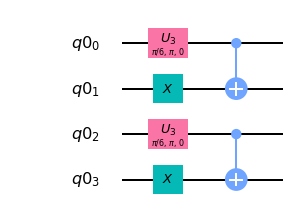

In [5]:
qr = QuantumRegister(4)
source_circ = QuantumCircuit(qr)

source_circ.x(qr[1]);
source_circ.u3(theta, pi, 0, qr[0]);
source_circ.cx(qr[0], qr[1]);
source_circ.x(qr[3])
source_circ.u3(theta, pi , 0, qr[2])
source_circ.cx(qr[2], qr[3]);

control_qubits = [qr[0], qr[1]]
target_qubits = [qr[2], qr[3]]

source_circ.draw(output='mpl')

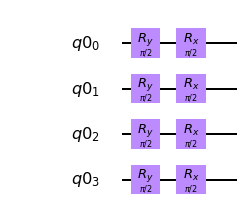

In [6]:
twirl_circ = QuantumCircuit(qr)

# Create a random integer between 0 and 11
random_idx = np.random.randint(12)

# Add a random bilateral rotation to the circuit, applied to qubits 0 and 1 (control qubits)
bilateral_rotation(twirl_circ, control_qubits, random_idx)

# Add a random bilateral rotation to the circuit, applied to qubits 2 and 3 (target qubits)
bilateral_rotation(twirl_circ, target_qubits, random_idx)

twirl_circ.draw(output='mpl')

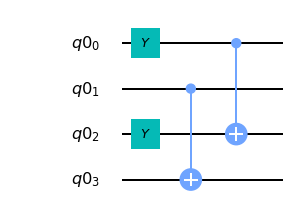

In [7]:
purification_circ = QuantumCircuit(qr)

# Implement a Pauli-Y gate on Alice's control qubit
purification_circ.y(control_qubits[0])

# Implement a Pauli-Y gate on Alice's target qubit
purification_circ.y(target_qubits[0]);

purification_circ.cx(control_qubits[0], target_qubits[0])
purification_circ.cx(control_qubits[1], target_qubits[1])
    
purification_circ.draw(output='mpl')

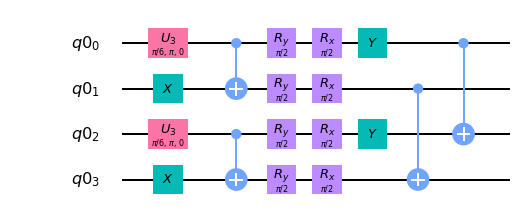

In [8]:
experiment_circ = source_circ + twirl_circ + purification_circ

experiment_circ.draw(output='mpl')

Job Status: job has successfully run


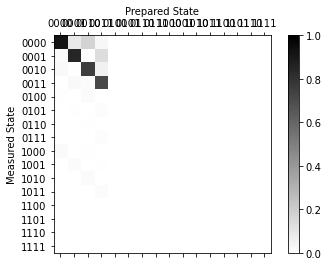

In [9]:
#readout calibration measurements
clz, state_labels = complete_meas_cal(qr = experiment_circ.qregs[0], circlabel = 'measerrormitcal')
# doing calibration only for qbit 0 and 1, for 00, 10, 01, 11
cal_circuit = [clz[0], clz[1], clz[2], clz[3]]
cal_job = execute(cal_circuit, backend = ibmq_device, shots = 8192, optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()

In [10]:
bits = ['0000', '1000', '0100', '1100', 
        '0001', '1001', '0101', '1101',
        '0010', '1010', '0110', '1110', 
        '0011', '1011', '0111', '1111']

counts = [0,0,0,0]
for i in range(4):
    counts[i] = calres.get_counts(cal_circuit[i])
    for bit in bits:
        if bit not in counts[i]:
            counts[i][bit] = 0

m_IZ = [0,0,0,0]
m_ZI = [0,0,0,0]
m_ZZ = [0,0,0,0]
for i in range(4):
    for num, bit in enumerate(bits):
        if num % 4 == 0 or num % 4 == 1:
            m_IZ[i] += float(counts[i][bit]) / 8192
        if num % 4 == 2 or num % 4 == 3:
            m_IZ[i] -= float(counts[i][bit]) / 8192
        if num % 4 == 0 or num % 4 == 2:
            m_ZI[i] += float(counts[i][bit]) / 8192
        if num % 4 == 1 or num % 4 == 3:
            m_ZI[i] -= float(counts[i][bit]) / 8192
        if num % 4 == 0 or num % 4 == 3:
            m_ZZ[i] += float(counts[i][bit]) / 8192
        if num % 4 == 1 or num % 4 == 2:
            m_ZZ[i] -= float(counts[i][bit]) / 8192

M = [[1,  1,  1,  1], 
     [1,  1, -1, -1], 
     [1, -1,  1, -1], 
     [1, -1, -1,  1]]
Minv = np.linalg.inv(M)

beta_IZ = np.dot(Minv, m_IZ)
beta_ZI = np.dot(Minv, m_ZI)
beta_ZZ = np.dot(Minv, m_ZZ)

b_vec = [beta_IZ[0], beta_ZI[0], beta_ZZ[0]]
B = [beta_IZ[1:], beta_ZI[1:], beta_ZZ[1:]]
Binv = np.linalg.inv(B)

print(B)
print(b_vec)

[array([ 0.02105713,  0.00250244, -0.00360107]), array([ 0.00244141, -0.00134277, -0.00024414]), array([ 0.02227783,  0.00018311, -0.00384521])]
[0.96026611328125, 0.9481201171875, 0.91790771484375]


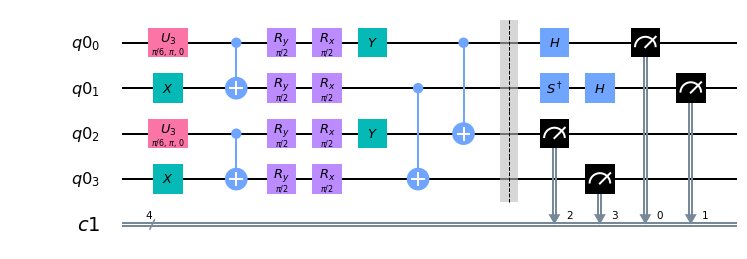

In [11]:
# defining tomography circuits
qcz = state_tomography_circuits(experiment_circ,qr)
# qiskit creates all 81 tomography circuits for 4 qbits, we want just a subset of that:
# the nine circuits are in the order [XZZX, XZZY, XZZZ, YZZX, YZZY, YZZZ, ZZZX, ZZZY, ZZZZ] <-- this is not true
qst_circuit = [qcz[8],qcz[17],qcz[26],qcz[35],qcz[44],qcz[53],qcz[62],qcz[71],qcz[80]]

# drawing one of the tomography circuits to check
qst_circuit[1].draw(output='mpl')

In [12]:
backends = ['simulator', 'simulator_noise', ibmq_device]

paulis = [('X','X','Z','Z'),('Y','X','Z','Z'),('Z','X','Z','Z'),
          ('X','Y','Z','Z'),('Y','Y','Z','Z'),('Z','Y','Z','Z'),
          ('X','Z','Z','Z'),('Y','Z','Z','Z'),('Z','Z','Z','Z')]

basis = ['XX','YX','ZX',
         'XY','YY','ZY',
         'XZ','YZ','ZZ']

for num, backend in enumerate(backends):
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '01': 0, '10': 0, '11': 0}})
    state_df = pd.DataFrame(data=[state,state,state,state])
    
    if num == 0:
        job_sim = execute(qst_circuit, ibmq_simulator, shots=8192)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 1:
        job_sim_noise = execute(qst_circuit, ibmq_simulator, shots=8192,
                                 noise_model=noise_model, 
                                 coupling_map=coupling_map, 
                                 basis_gates=basis_gates)
        tom = StateTomographyFitter(job_sim_noise.result(), qst_circuit)
    if num == 2:
        job_dev = execute(qst_circuit, backend, shots=8192)
        job_monitor(job_dev)
        tom = StateTomographyFitter(job_dev.result(), qst_circuit)
    
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit] = 0
    
    # No idea yet how many possible outcomes of purification protocol, where the final state is hopefully one of
    # psi, IX @ psi, IZ @ psi, IZ @ IX @ psi. We store all 4 seperately, to then transform
    # the resulting density matrices appropriately before finding fidelity
    for i in range(4):
        for j in range(9):
            state_df.loc[i][basis[j]] = {'00': tom.data[(paulis[j])][bits[4*i]],
                                         '01': tom.data[(paulis[j])][bits[4*i+2]],
                                         '10': tom.data[(paulis[j])][bits[4*i+1]],
                                         '11': tom.data[(paulis[j])][bits[4*i+3]]}

    if num == 0:
        state_sim = state_df
        print('The full state for the simulator is', state_sim)
    if num == 1:
        state_sim_noise = state_df
        print('The full state for the noisy simulator is', state_sim_noise)
    if num == 2:
        state_dev = state_df
        print('The full state for the device is', state_dev)

The full state for the simulator is                                                  XX  \
0  {'00': 2080, '01': 1566, '10': 1485, '11': 2048}   
1              {'00': 0, '01': 0, '10': 0, '11': 0}   
2              {'00': 0, '01': 0, '10': 0, '11': 0}   
3          {'00': 496, '01': 0, '10': 0, '11': 517}   

                                              YX  \
0  {'00': 963, '01': 838, '10': 756, '11': 1063}   
1  {'00': 1071, '01': 790, '10': 772, '11': 974}   
2       {'00': 257, '01': 0, '10': 0, '11': 223}   
3       {'00': 255, '01': 0, '10': 0, '11': 230}   

                                               ZX  \
0   {'00': 1029, '01': 759, '10': 744, '11': 976}   
1  {'00': 1021, '01': 796, '10': 795, '11': 1086}   
2        {'00': 253, '01': 0, '10': 0, '11': 243}   
3        {'00': 234, '01': 0, '10': 0, '11': 256}   

                                               XY  \
0   {'00': 1069, '01': 802, '10': 751, '11': 993}   
1        {'00': 248, '01': 0, '10': 0, '11': 255}   
2 

In [13]:
# defining the matrices to construct the density matrices
I_matrix = np.matrix('1, 0; 0, 1')
X_matrix = np.matrix('0, 1; 1, 0')
Y_matrix = np.matrix('0, 0-1j; 0+1j, 0')
Z_matrix = np.matrix('1, 0; 0, -1')

Iden = np.kron(I_matrix,I_matrix)

IXPaul = np.kron(I_matrix,X_matrix)
IYPaul = np.kron(I_matrix,Y_matrix)
IZPaul = np.kron(I_matrix,Z_matrix)
XIPaul = np.kron(X_matrix,I_matrix)
YIPaul = np.kron(Y_matrix,I_matrix)
ZIPaul = np.kron(Z_matrix,I_matrix)

XXPaul = np.kron(X_matrix,X_matrix)
XYPaul = np.kron(X_matrix,Y_matrix)
XZPaul = np.kron(X_matrix,Z_matrix)

YXPaul = np.kron(Y_matrix,X_matrix)
YYPaul = np.kron(Y_matrix,Y_matrix)
YZPaul = np.kron(Y_matrix,Z_matrix)

ZXPaul = np.kron(Z_matrix,X_matrix)
ZYPaul = np.kron(Z_matrix,Y_matrix)
ZZPaul = np.kron(Z_matrix,Z_matrix)

In [14]:
# there are 4 density matrices to calculate for each of sim, sim_noise and dev

# XX, XY, XZ etc are 9 total r_xx etc terms to calculate
r_exp = np.zeros((4, 9))
# there are three IX type terms and each can be calculated three ways (from XX, YX, ZX for IX)
r_IP = np.zeros((4, 9))
r_PI = np.zeros((4, 9))
r_IPavg = np.zeros((4, 3))
r_PIavg = np.zeros((4, 3))

m = np.zeros((4,9,3))
r_corr = np.zeros((4,9,3))
r_IPavg_corr = np.zeros((4, 3))
r_PIavg_corr = np.zeros((4, 3))

state_tot=[state_sim,state_sim_noise,state_dev]
rho=[0,0,0,0]

for stat, states in enumerate(state_tot):
    rhof = [0,0,0,0]
    for i in range(4):
        for j in range(9):
            #check if you don't divide by 0
            if (states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*1) == 0:
                r_exp[i,j] = 0
                r_IP[i,j] = 0
                r_PI[i,j] = 0
            else:
                r_exp[i,j] = (states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(-1) + states[basis[j]][i]['01']*(-1) + states[basis[j]][i]['11']*1)/(states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*1)
                r_IP[i,j] = (states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(-1) + states[basis[j]][i]['11']*(-1))/(states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*1)
                r_PI[i,j] = (states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(-1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*(-1))/(states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*1)
            
    for i in range(4):
        for j in range(3):
                r_IPavg[i,j]  = (r_IP[i,j] + r_IP[i,j+3] + r_IP[i,j+6])/3
                r_PIavg[i,j] = (r_PI[i,3*j] + r_PI[i,3*j+1] + r_PI[i,3*j+2])/3
    for i in range(4):
        rhof[i] = (1/4)*(Iden + r_exp[i,0]*XXPaul + r_exp[i,1]*XYPaul + r_exp[i,2]*XZPaul
                              + r_exp[i,3]*YXPaul + r_exp[i,4]*YYPaul + r_exp[i,5]*YZPaul
                              + r_exp[i,6]*ZXPaul + r_exp[i,7]*ZYPaul + r_exp[i,8]*ZZPaul
                              + r_IPavg[i,0]*IXPaul + r_PIavg[i,0]*XIPaul
                              + r_IPavg[i,1]*IYPaul + r_PIavg[i,1]*YIPaul
                              + r_IPavg[i,2]*IZPaul + r_PIavg[i,2]*ZIPaul)
        rho[stat] = rhof

# performing corrections for readout error and storing result in another density matrix
for i in range(4):
    for num, bas in enumerate(basis):
        m[i,num,:] = [r_IP[i,num], r_PI[i, num], r_exp[i,num]]
        r_corr[i,num] = np.dot(Binv, np.subtract(m[i,num,:],b_vec))

rho_corr = [0,0,0,0]
for i in range(4):
    for j in range(3):
            r_IPavg_corr[i,j] = (r_corr[i,j][0] + r_corr[i,j+3][0] + r_corr[i,j+6][0])/3
            r_PIavg_corr[i,j] = (r_corr[i,3*j][1] + r_corr[i,3*j+1][1] + r_corr[i,3*j+2][1])/3

    rho_corr[i] = (1/4)*(Iden + r_corr[i,0][2]*XXPaul + r_corr[i,1][2]*XYPaul + r_corr[i,2][2]*XZPaul
                              + r_corr[i,3][2]*YXPaul + r_corr[i,4][2]*YYPaul + r_corr[i,5][2]*YZPaul
                              + r_corr[i,6][2]*ZXPaul + r_corr[i,7][2]*ZYPaul + r_corr[i,8][2]*ZZPaul
                              + r_IPavg_corr[i,0]*IXPaul + r_PIavg_corr[i,0]*XIPaul
                              + r_IPavg_corr[i,1]*IYPaul + r_PIavg_corr[i,1]*YIPaul
                              + r_IPavg_corr[i,2]*IZPaul + r_PIavg_corr[i,2]*ZIPaul)

rho[3] = rho_corr

for ind in range(4):
    rho[ind][1] = ZIPaul @ rho[ind][1] @ ZIPaul
    rho[ind][2] = XIPaul @ rho[ind][2] @ XIPaul
    rho[ind][3] = XIPaul @ IZPaul @ rho[ind][3] @ IZPaul @ XIPaul
    
# finding the average density matrix from the four possible outcomes
rho_avg = [0,0,0,0]
for i in range(4):
    rho_avg[i] = np.mean(np.array([rho[i][0], rho[i][1], rho[i][2], rho[i][3]]), axis=0)

In [15]:
F_avg = [0,0,0,0]
for i in range(4):
    F_avg[i] = state_fidelity(phi_plus, rho_avg[i], validate=False)
    
print('Simulator Fidelity:', F_avg[0])
print('Noisy Simulator Fidelity:', F_avg[1])
print('Device Fidelity:', F_avg[2])
print('Calibrated Device Fidelity', F_avg[3])

Simulator Fidelity: 0.3253642280191641
Noisy Simulator Fidelity: 0.27197962499743394
Device Fidelity: 0.27634173250233085
Calibrated Device Fidelity 253.04624078609973
